T12: 1hr @ 0.5kHz vs T13: 0.5hr @ 1kHz. Both 0.75 Er and 1.5 Er targets.

In [5]:
import numpy as np
import glob as gb
import os
import matplotlib.pyplot as plt
import lifetime as lf

%matplotlib notebook

In [6]:
save = True

In [7]:
def getSample(file):
    # Get smple name from file
    sample = os.path.basename(file)
    sample = os.path.splitext(sample)[0]
    return sample

def getSampleNo(file):
    # Get sample number 
    sample = os.path.basename(file)
    sample = os.path.splitext(sample)[0]
    # For files with underscore
    sample = sample.split('_')[0]
    return int(sample[1:])

# Lifetime

In [8]:
# select files to analyse
files = gb.glob('./Lifetime/*.txt')

# Select only T12 and T13
files = [x for x in files if '12' in x or '13' in x]

In [9]:
# Select the required pump
pump = 2
files = [x for x in files if '_2ms' in x]
files

['./Lifetime\\T12_2ms.txt', './Lifetime\\T13_2ms.txt']

## T12

<IPython.core.display.Javascript object>


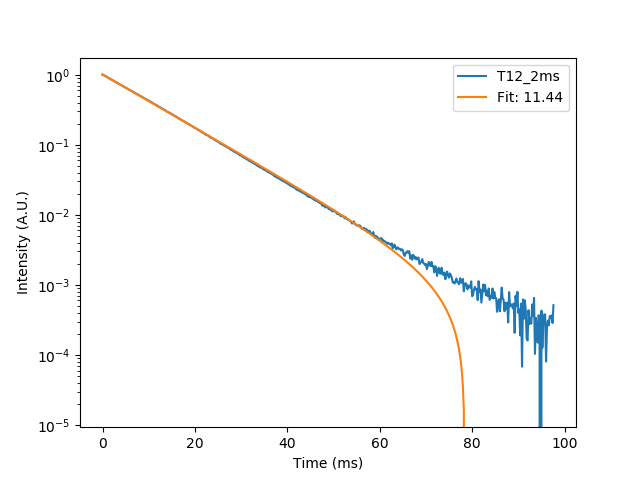

In [10]:
# Plot data
fig = plt.figure()
ax = fig.add_subplot(111)

f = files[0]

data = np.genfromtxt(fname=f, delimiter=',', dtype=float, skip_header=10, usecols=(0,1))
x = data[:,0]/1E6  # Convert time from us to ms
y = data[:,1]

x, y = lf.decay.drop_pump(x, y, pump=pump)
x, y = lf.decay.reject(x, y, reject_end=100)
x, y = lf.decay.normalise(x, y, point='start')

# Plot raw data
ax.plot(x, y, label=getSample(f))

# Fit and plot
popt = lf.decay.fit_decay(x, y)
ax.plot(x, lf.decay.decay_fn(x, *popt), label='Fit: {:.2f}'.format(popt[1]))

ax.set_yscale('log')
# plt.xlim(0, 100)
plt.xlabel('Time (ms)')
plt.ylabel('Intensity (A.U.)')
plt.legend()

if save:
    plt.savefig('./lifetime_' + getSample(f))

## T13

<IPython.core.display.Javascript object>


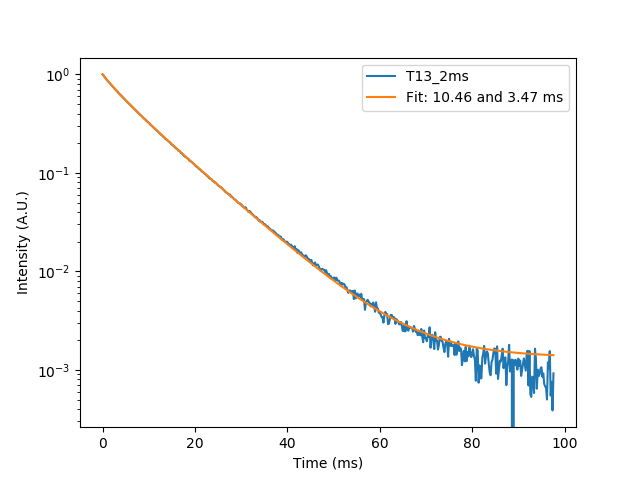

In [11]:
# Plot data
fig = plt.figure()
ax = fig.add_subplot(111)

f = files[1]

data = np.genfromtxt(fname=f, delimiter=',', dtype=float, skip_header=10, usecols=(0,1))
x = data[:,0]/1E6  # Convert time from us to ms
y = data[:,1]

x, y = lf.decay.drop_pump(x, y, pump=pump)
x, y = lf.decay.reject(x, y, reject_end=100)
x, y = lf.decay.normalise(x, y, point='start')

# Plot raw data
ax.plot(x, y, label=getSample(f))

# Fit and plot
popt = lf.decay.fit_decay2(x, y)
ax.plot(x, lf.decay.decay_fn2(x, *popt), label='Fit: {:.2f} and {:.2f} ms'.format(popt[1], popt[3]))

ax.set_yscale('log')
# plt.xlim(0, 35)
plt.xlabel('Time (ms)')
plt.ylabel('Intensity (A.U.)')
plt.legend()

if save:
    plt.savefig('./lifetime_' + getSample(f))

## Together (single exp)

<IPython.core.display.Javascript object>


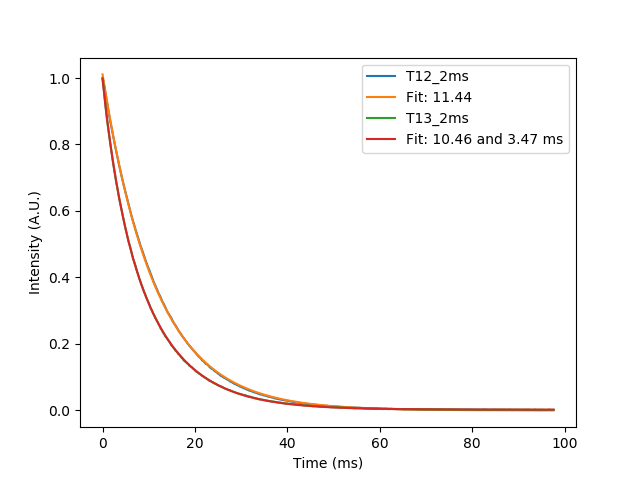

In [12]:
# Plot data
fig = plt.figure()
ax = fig.add_subplot(111)

##############
# T12
f = files[0]
data = np.genfromtxt(fname=f, delimiter=',', dtype=float, skip_header=10, usecols=(0,1))
x = data[:,0]/1E6  # Convert time from us to ms
y = data[:,1]

x, y = lf.decay.drop_pump(x, y, pump=pump)
x, y = lf.decay.reject(x, y, reject_end=100)
x, y = lf.decay.normalise(x, y, point='start')

# Plot raw data
ax.plot(x, y, label=getSample(f))

# Fit and plot
popt = lf.decay.fit_decay(x, y)
ax.plot(x, lf.decay.decay_fn(x, *popt), label='Fit: {:.2f}'.format(popt[1]))

############
# T13
f = files[1]

data = np.genfromtxt(fname=f, delimiter=',', dtype=float, skip_header=10, usecols=(0,1))
x = data[:,0]/1E6  # Convert time from us to ms
y = data[:,1]

x, y = lf.decay.drop_pump(x, y, pump=pump)
x, y = lf.decay.reject(x, y, reject_end=100)
x, y = lf.decay.normalise(x, y, point='start')

# Plot raw data
ax.plot(x, y, label=getSample(f))

# Fit and plot
popt = lf.decay.fit_decay2(x, y)
ax.plot(x, lf.decay.decay_fn2(x, *popt), label='Fit: {:.2f} and {:.2f} ms'.format(popt[1], popt[3]))

# ax.set_yscale('log')
# plt.xlim(0, 100)
# plt.ylim(0.1, 1)
plt.xlabel('Time (ms)')
plt.ylabel('Intensity (A.U.)')
plt.legend()

if save:
    plt.savefig('./lifetime_both')

# Spectrum

In [14]:
files = gb.glob('./Spectrum/*.txt')
files = sorted(files, key=lambda x: getSampleNo(x))

In [15]:
# Select only T12 and T13
files = [x for x in files if '12' in x or '13' in x]
files

['./Spectrum\\T12.txt', './Spectrum\\T13.txt']

<IPython.core.display.Javascript object>


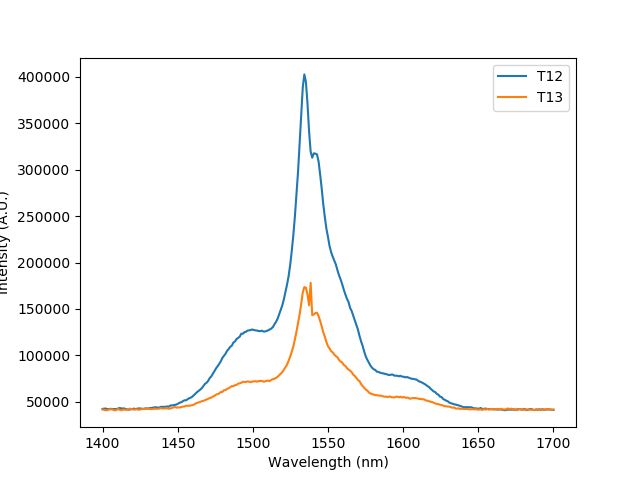

In [16]:
# Unnormalised
fig = plt.figure()
ax = fig.add_subplot(111)

imax = []
for f in files:
    # Load data
    data = np.genfromtxt(fname=f, delimiter=',', dtype=float, skip_header=22, usecols=(0,1))
    x = data[:,0]
    y = data[:,1]
    imax.append(max(y))

    ax.plot(x, y, label=getSample(f))

    plt.legend()
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity (A.U.)')
    
if save:
    plt.savefig('./spectrum_raw')

In [21]:
print('Ratio of maximum intensities: {:.3f}'.format(imax[0]/imax[1]))

Ratio of maximum intensities: 2.261


<IPython.core.display.Javascript object>


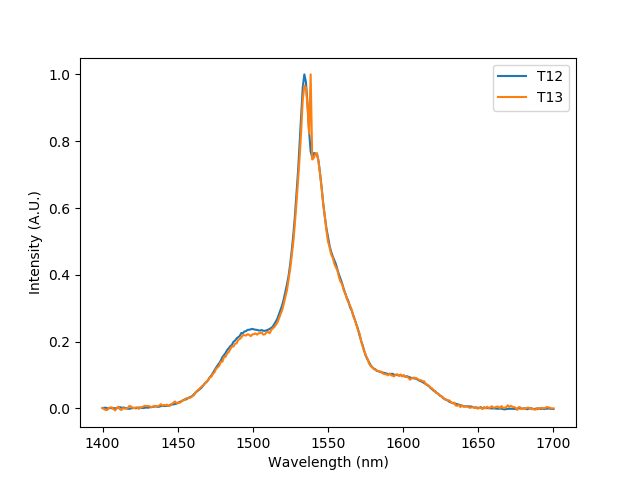

In [45]:
# Normalised
fig = plt.figure()
ax = fig.add_subplot(111)

for f in files:
    # Load data
    data = np.genfromtxt(fname=f, delimiter=',', dtype=float, skip_header=22, usecols=(0,1))
    x = data[:,0]
    y = data[:,1]

    # Normalise
    x, y = lf.spectrum.normalise(x, y)

    ax.plot(x, y, label=getSample(f))

    plt.legend()
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity (A.U.)')
    
if save:
    plt.savefig('./spectrum_normalised')

# Prism Coupler Data

| Sample | n      | d      |
|--------|--------|--------|
|   T12  | 1.4914 | 0.5659 |
| T13    | 1.6235 | 0.3379 |

# Purcell Factor

Comparing air and covered in cassia oil. Note only T13 supports waveguiding.

T12 - 1.096184

T13 - 1.152419 (WG) or 1.268119 (no WG)

In [3]:
from IPython.display import IFrame
IFrame("./purcell_factor_indivd_T12.png", width=900, height=500)

In [4]:
IFrame("./purcell_factor_indivd_T13.png", width=900, height=500)